# Compare slope of ideal experiment with calculated values for dissipation

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:35139' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35139,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42151,Total threads: 4
Dashboard: /proxy/43803/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38243,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [2]:
trange = 50
t0 = 3700
data = tt.collect_data(
            exptname="debug_ideal-20",
            rawdata = ["rho","u","v","ahh","KE_visc","KE_horvisc","PE_to_KE","kvu","dKE_dt","KE"],
            timerange = (t0 - trange,t0 + trange)
        ).sel(yb = slice(-50,50))

data = data.assign_coords(
    {"xb" : data.xb * 1000,
     "yb" : data.yb * 1000,
     "time":data.time * 3600
}).load()
N = tt.getN(data.rho).rename("N").mean("time")
efuncs = {}
efuncs["ideal-20"] = tt.ShootingVmodes(
    xr.merge(
        [
            data.bathy.rename("H"),
            N
        ]).sel(xb = slice(400000,405000),yb = slice(0,5000)).load().chunk({"xb":1,"yb":1})
)
phi = efuncs["ideal-20"].U.isel(xb = 0,yb = 0)
U = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.u).fillna(0).integrate("zl").load() 
V = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.v).fillna(0).integrate("zl").load()
ahh = data.ahh.load()
wavelength = efuncs["ideal-20"].Wavelength
N = N.isel(xb = 50,yb = 10) ## Do this for simplicity to match dimensions later for vertical integral

loading rho...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading KE_visc...	done.
loading KE_horvisc...	done.
loading PE_to_KE...	done.
loading kvu...	done.
loading dKE_dt...	done.
loading KE...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/jobfs/130224836.gadi-pbs/ipykernel_22762/3578353095.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  U = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.u).fillna(0).integrate("zl").load()
/jobfs/130224836.gadi-pbs/ipykernel_22762/3578353095.py:25: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  V = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.v).fillna(0).integrate("zl").load()


## Calculate EF again, avoiding horizontal integrals

$ \large \partial_z P = b - \partial_t w $

$ \large \partial_t b = -w N^2 $

$ \large \partial_z w = - \partial u_x - \partial v_y $

### Combinine to get an expression for P. Recall $u(x,y,z,t) = U(x,y,t) \phi(z)$

$ \large \partial_z P = \int^{t'}_0 -w N^2 dt' - \partial_t w $

$ \large P = \rho_0 \int^z_0 \left(A(z') (U_{xt} + V_{yt}) - B(z') \int^{t'}_0 (U_x + V_y) dt' \right)dz' $

$ \large A(z) = \int^{z}_0 \phi(z') dz' $

$ \large B(z) = \int^{z}_0 N^2(z')\phi(z') dz' $


where $\phi$ is the horizontal velocity eigenfunction, and tildes denote eigenvalues, i.e the horizontal components of velocities s.t $u = \tilde{u}(x,y,t) \phi(z)$

What I've found is that the coefficient of B(z) is huge compared to the other terms, and this integral-in-time coefficient doesn't have the wave-like spatial pattern. It's therefore because of this term that the pressure value doesn't look right! Maybe this is due errors in not integrating over exact tidal periods?


In [7]:
import scipy
def integrate(array,dim):
    def scipy_integrate(data):
        full_integral = scipy.integrate.trapezoid(data,x = array[dim])
        return (data * 0) + full_integral - scipy.integrate.cumulative_trapezoid(
            data,
            x = array[dim],
            initial = 0
            )

    if len(array.dims) == 1:
        out = scipy_integrate(array)
    else:
        out = np.apply_along_axis(scipy_integrate,array.get_axis_num(dim),array)

    return xr.DataArray(
        data = out,
        dims = array.dims,
        coords = array.coords
    )


def EnergyFlux(U,V,phi,N):
    rho0 = 1023
    A = integrate(phi,"zl")
    B = integrate(phi * N**2 , "zl")
    UxVy = (U.differentiate("xb") + V.differentiate("yb")).load()
    P = rho0 * (
        integrate(
            B * integrate(
                UxVy,
                "time"
            ),
            "zl"
        )
    )

    return A,B,P
A,B, P= EnergyFlux(U.isel(mode = 0),V.isel(mode = 0),phi.isel(mode = 0),N)


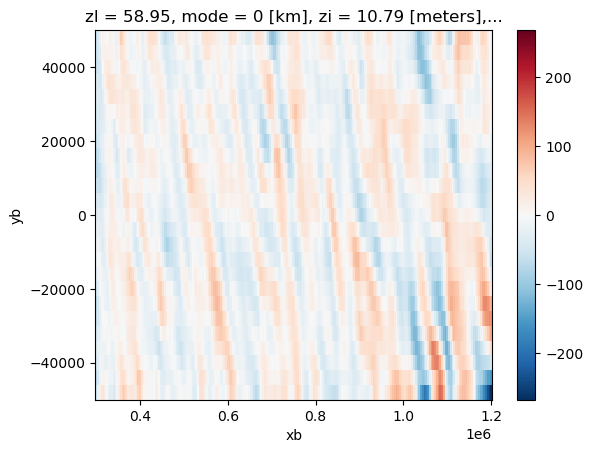

In [8]:
P.sel(xb = slice(300000,1200000)).isel(time = 50,zl = 10).plot()

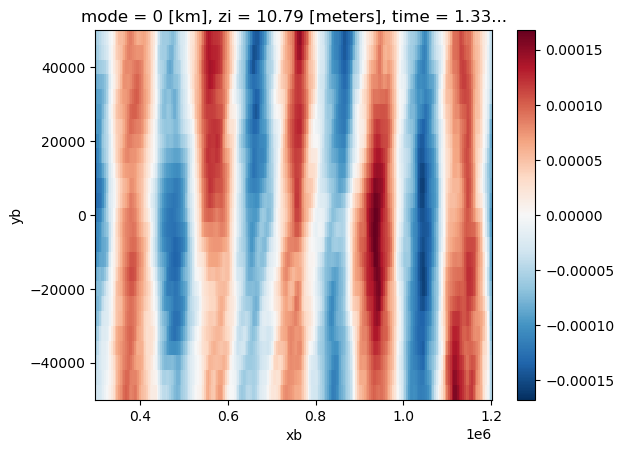

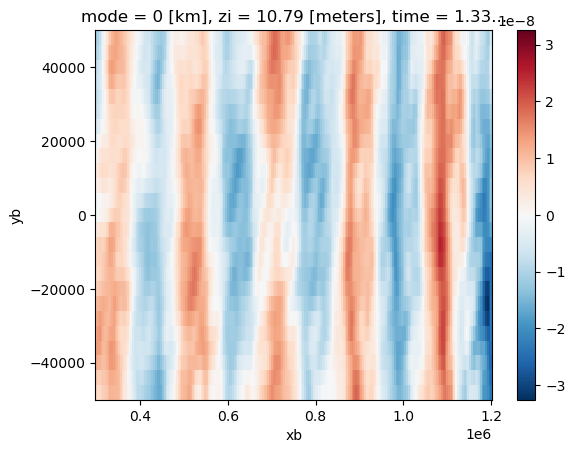

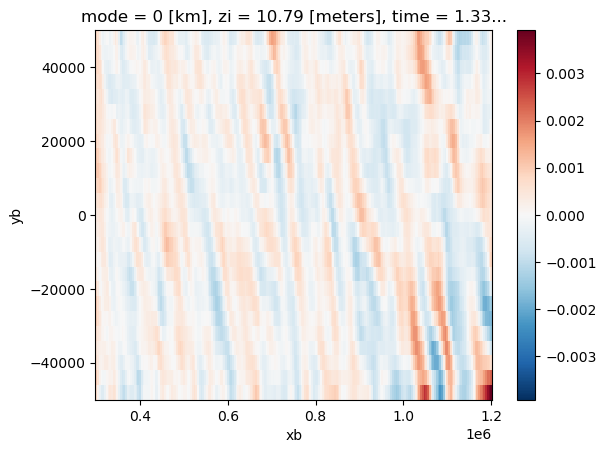

In [20]:
UxVy = (U.differentiate("xb") + V.differentiate("yb")).sel(xb = slice(300000,1200000)).isel(mode = 0).load()
B = (N**2 * phi.isel(mode = 0)).integrate("zl")
UxVy.isel(time = 50).plot()
plt.figure()
UxVy.differentiate("time").isel(time = 50).plot()
plt.figure()
((integrate(UxVy,"time") - UxVy.integrate("time")) * B).isel(time = 50).plot()


Text(0.5, 1.0, '$\\int Ux + Vx dt$')

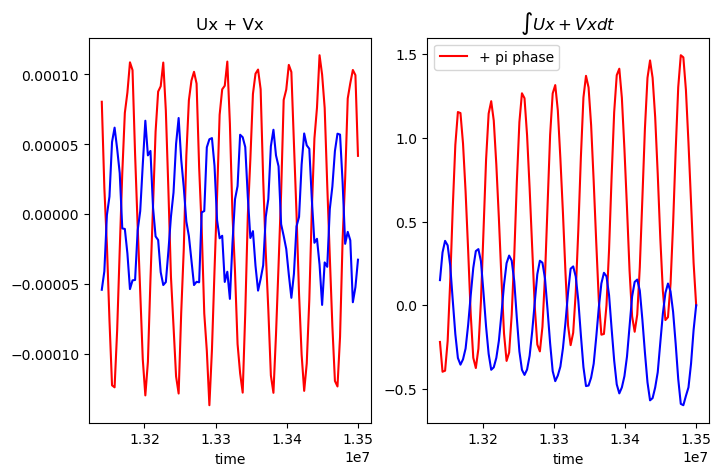

In [33]:
UxVy1 = (U.differentiate("xb") + V.differentiate("yb")).sel(xb = 600000,yb = 0,method = "nearest").isel(mode = 0).load()
UxVy2 = (U.differentiate("xb") + V.differentiate("yb")).sel(xb = 700000,yb = 0,method = "nearest").isel(mode = 0).load()

fig,ax = plt.subplots(1,2,figsize = (8,5))
UxVy1.plot(ax = ax[0],color = "red")
# integrate(UxVy1 - UxVy1.mean("time"),"time").plot(ax = ax[1],color = "red",label = "+ pi phase")
integrate(UxVy1 - UxVy1.mean("time"),"time").plot(ax = ax[1],color = "red",label = "+ pi phase")

UxVy2.plot(ax = ax[0],color = "blue")
# integrate(UxVy2 - UxVy2.mean("time"),"time").plot(ax = ax[1],color = "blue")
integrate(UxVy2 - UxVy2.mean("time"),"time").plot(ax = ax[1],color = "blue")
ax[1].legend()
ax[0].set_title("Ux + Vx")
ax[1].set_title(r"$\int Ux + Vx dt$")


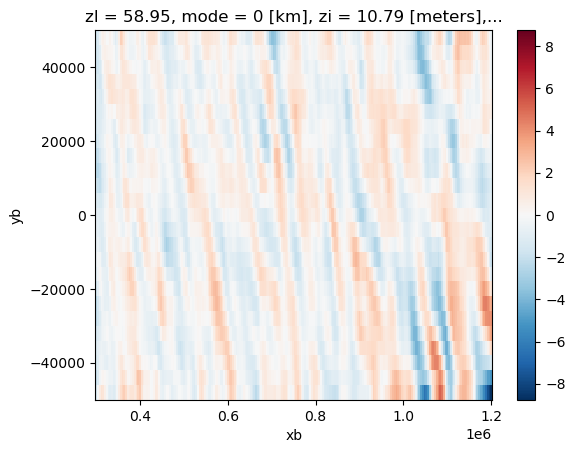

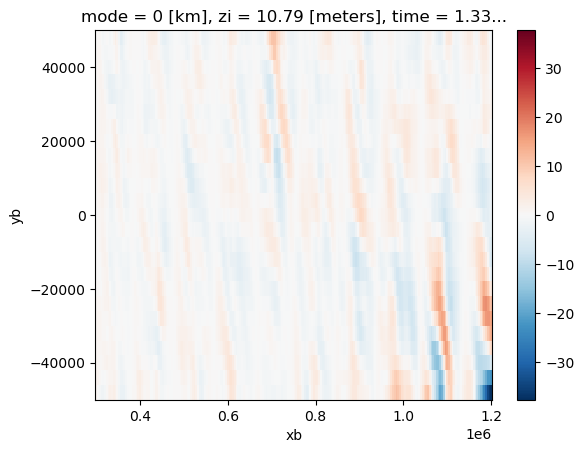

In [66]:
(P).sel(xb = slice(300000,1200000)).isel(zl = 10,time = 50).plot()
plt.figure()
(U * P).sel(xb = slice(300000,1200000)).isel(time = 50,mode = 0,zl = 10).plot()


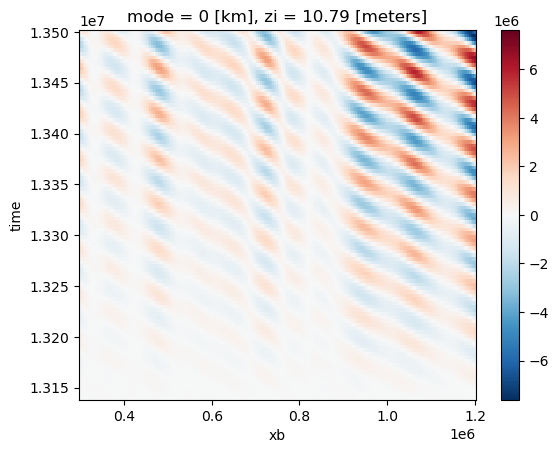

In [50]:
((U * phi).isel(mode = 0) * P).sel(xb = slice(300000,1200000)).integrate("zl").integrate("yb").plot()

## Plot each EF component and dissipation about a given box

Text(0.5, 1.0, 'Energy fluxes, PE to KE conversion and dissipation in a box subset of domain')

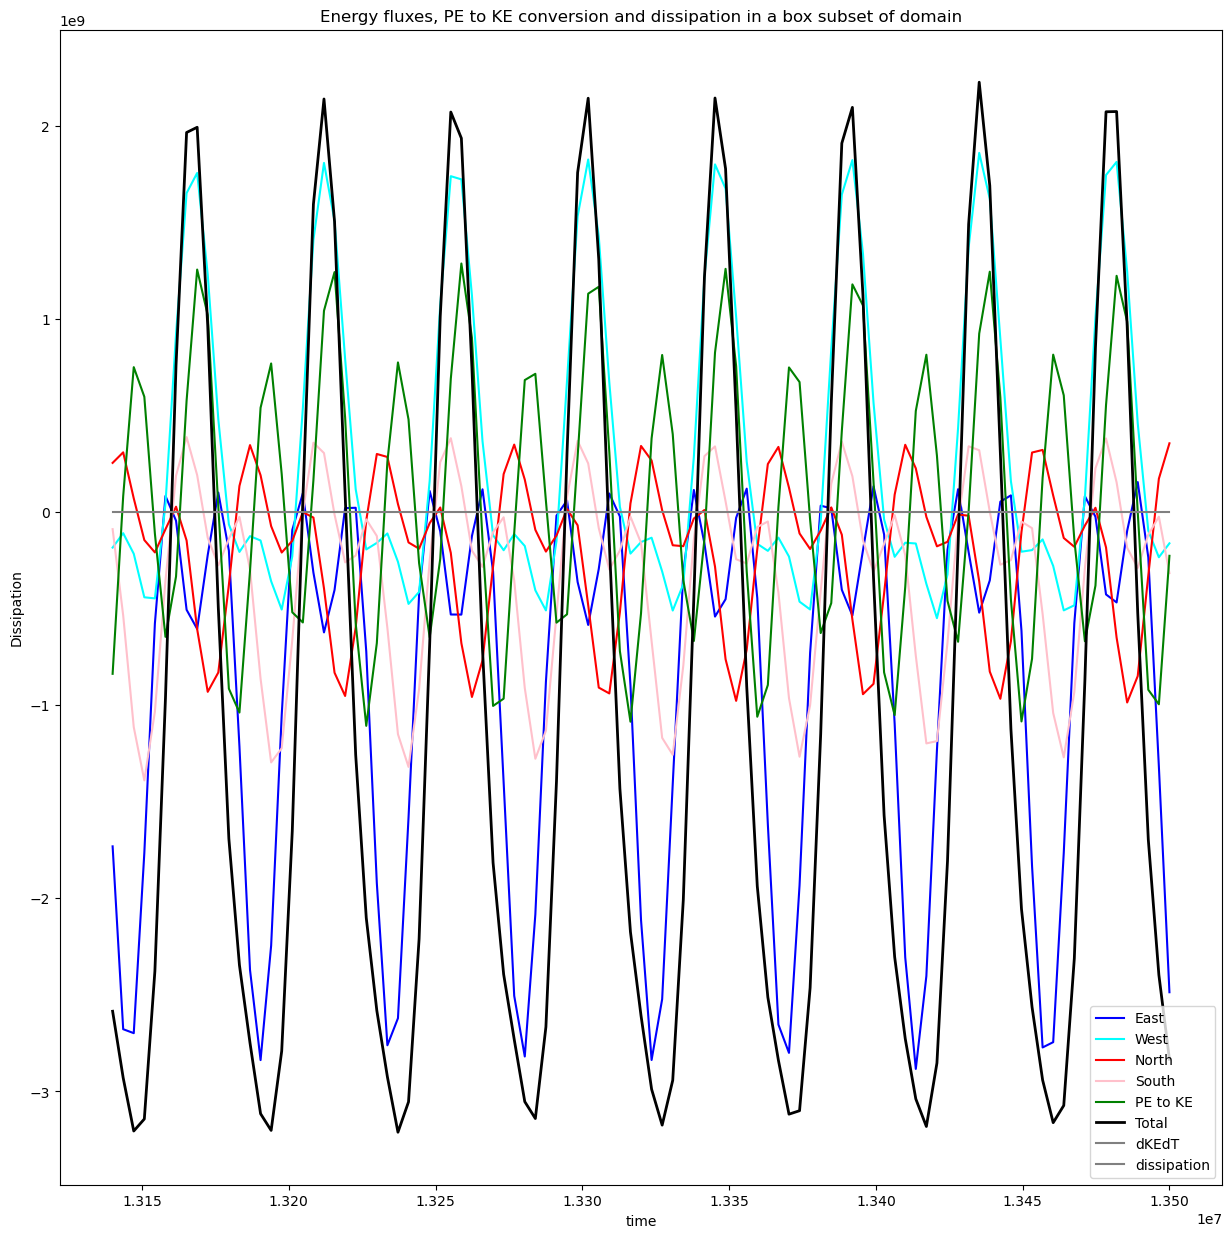

In [ ]:
xextent = [500000,600000]
yextent = [-40000,40000]
fig,ax = plt.subplots(1,figsize = (15,15))
EF_east = -1 * energies.EF_along.sel(
    xb = xextent[-1],method = "nearest"
    ).sel(yb = slice(yextent[0],yextent[1])).integrate("yb").sum("mode")
EF_west = energies.EF_along.sel(
    xb = xextent[0],method = "nearest"
    ).sel(yb = slice(yextent[0],yextent[1])).integrate("yb").sum("mode")
EF_north = -1 * energies.EF_across.sel(
    yb = yextent[-1],method = "nearest"
    ).sel(xb = slice(xextent[0],xextent[1])).integrate("xb").sum("mode")
EF_south = energies.EF_across.sel(
    yb = yextent[0],method = "nearest"
    ).sel(xb = slice(xextent[0],xextent[1])).integrate("xb").sum("mode")
PEtoKE = (data.PE_to_KE * data.zl).fillna(0).sel(xb = slice(500000,600000),yb = slice(-40000,40000)).sum("zl").integrate("yb").integrate("xb")

EF_east.plot(ax = ax,label = "East",color = "blue")
EF_west.plot(ax = ax,label = "West",color = "cyan")
EF_north.plot(ax = ax,label = "North",color = "red")
EF_south.plot(ax = ax,label = "South",color = "pink")
PEtoKE.plot(label = "PE to KE",color = "green")
(EF_east + EF_west + EF_north + EF_south + PEtoKE).plot(ax = ax,label = "Total",color = "black",linewidth = 2)
data.KE.sel(xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])).differentiate("time").integrate("yb").integrate("zl").integrate("xb").plot(ax = ax,label = "dKEdT",color = "grey")

energies.Dissipation.integrate("xb").integrate("yb").integrate("zl").sum("mode").plot(color = "grey",label = "dissipation")
ax.legend()
ax.set_title("Energy fluxes, PE to KE conversion and dissipation in a box subset of domain")

In [49]:
EF_east_tot = EF_east.isel(time = slice(0,99)).integrate('time').values
EF_west_tot = EF_west.isel(time = slice(0,99)).integrate('time').values
EF_north_tot = EF_north.isel(time = slice(0,99)).integrate('time').values
EF_south_tot = EF_south.isel(time = slice(0,99)).integrate('time').values
diss = energies.Dissipation.fillna(0).integrate("xb").integrate("yb").integrate("zl").sum("mode").integrate("time").values

print("Integrate energy sources & sinks \nfor box in middle of beam  over \nx,y,z, and ~integer tidal periods")
print()
print(f"EF East:\t\t{EF_east_tot:.1e}")
print(f"EF West:\t\t{EF_west_tot:.1e}")
print(f"EF North:\t\t{EF_north_tot:.1e}")
print(f"EF South:\t\t{EF_south_tot:.1e}")
print(f"EF total:   \t\t{(EF_east_tot + EF_west_tot + EF_north_tot + EF_south_tot):.1e}")
print(f"Horizontal Diss.:   \t{diss:.1e}")
print(f"PEtoKE:   \t\t{PEtoKE.isel(time = slice(0,99)).integrate('time').values:.1e}")
print("==================================")
print(f"Total of above:\t\t{(EF_east + EF_west + EF_north + EF_south + PEtoKE).isel(time = slice(0,99)).integrate('time').values:.1e}")
print(f"actual delta KE:\t{data.KE.sel(xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])).differentiate('time').fillna(0).integrate('yb').integrate('zl').integrate('xb').isel(time = slice(0,99)).integrate('time').values:.1e}")
print("")
print("Missing terms? \nOr calculating these terms incorrectly?")


Integrate energy sources & sinks 
for box in middle of beam  over 
x,y,z, and ~integer tidal periods

EF East:		-3.2e+14
EF West:		1.3e+14
EF North:		-7.6e+13
EF South:		-1.2e+14
EF total:   		-3.8e+14
Horizontal Diss.:   	1.4e+12
PEtoKE:   		3.3e+13
Total of above:		-3.5e+14
actual delta KE:	8.0e+09

Missing terms? 
Or calculating these terms incorrectly?


In [52]:
data.u

<xarray.DataArray 'u' (time: 101, zl: 100, yb: 25, xb: 376)> Size: 380MB
array([[[[            nan,             nan,             nan, ...,
           8.43957812e-03,  5.59727848e-03, -8.25669765e-02],
         [            nan,             nan,             nan, ...,
          -2.86143608e-02, -3.35134715e-02, -8.23800713e-02],
         [            nan,             nan,             nan, ...,
          -2.80845780e-02, -5.83872087e-02, -1.11750245e-01],
         ...,
         [            nan,             nan,             nan, ...,
          -1.25472248e-01, -2.11130694e-01, -2.71421075e-01],
         [            nan,             nan,             nan, ...,
          -3.39039147e-01, -4.04996514e-01, -3.86005461e-01],
         [            nan,             nan,             nan, ...,
          -5.36190927e-01, -5.14007628e-01, -3.89651388e-01]],

        [[            nan,             nan,             nan, ...,
           7.43604824e-03,  4.57780808e-03, -8.18170086e-02],
         [            nan,             nan,             nan, ...,
          -3.82804349e-02, -4.27962467e-02, -9.00230482e-02],
         [            nan,             nan,             nan, ...,
          -3.02570183e-02, -6.24331161e-02, -1.16667375e-01],
...
                      nan, -4.48879786e-04, -7.36877648e-03],
         [            nan,             nan,             nan, ...,
                      nan,  2.52933595e-02,  7.63807492e-03],
         [            nan,             nan,             nan, ...,
           4.07139137e-02,  3.22964899e-02,  3.15165594e-02]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan, -1.10870805e-02],
         [            nan,             nan,             nan, ...,
                      nan,  1.89010352e-02,  3.93056404e-03],
         [            nan,             nan,             nan, ...,
                      nan,  2.56283041e-02,  2.66343430e-02]]]],
      dtype=float32)
Coordinates:
  * zl       (zl) float64 800B 2.704 8.126 13.58 ... 5.339e+03 5.443e+03
    zi       float64 8B 10.79
    lon      (yb, xb) float64 75kB 146.6 146.7 146.7 146.8 ... 164.2 164.3 164.3
    lat      (yb, xb) float64 75kB -42.65 -42.66 -42.68 ... -48.33 -48.35 -48.37
  * xb       (xb) float64 3kB -0.0 4e+03 8e+03 ... 1.492e+06 1.496e+06 1.5e+06
  * yb       (yb) float64 200B -4.8e+04 -4.4e+04 -4e+04 ... 4.4e+04 4.8e+04
  * time     (time) float64 808B 1.314e+07 1.314e+07 ... 1.35e+07 1.35e+07

In [ ]:
theta

In [17]:
print(f"dKEdt:\t{data.KE.sel(xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])).fillna(0).integrate('yb').integrate('zl').integrate('xb').isel(time = slice(0,99)).isel(time = [0,98]).diff('time').values}")

dKEdt:	[7.32208763e+09]


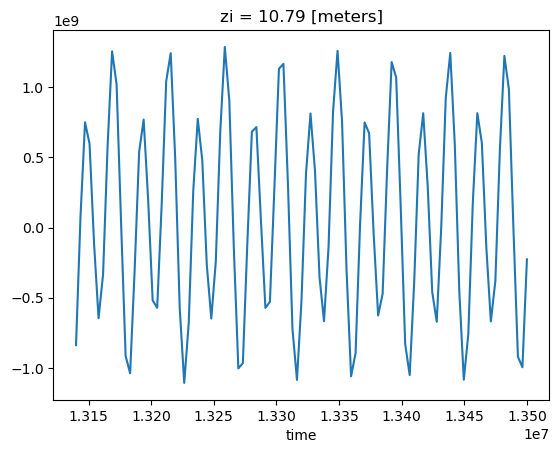

In [26]:
(data.PE_to_KE * data.zl).fillna(0).sel(xb = slice(500000,600000),yb = slice(-40000,40000)).sum("zl").integrate("yb").integrate("xb").plot()


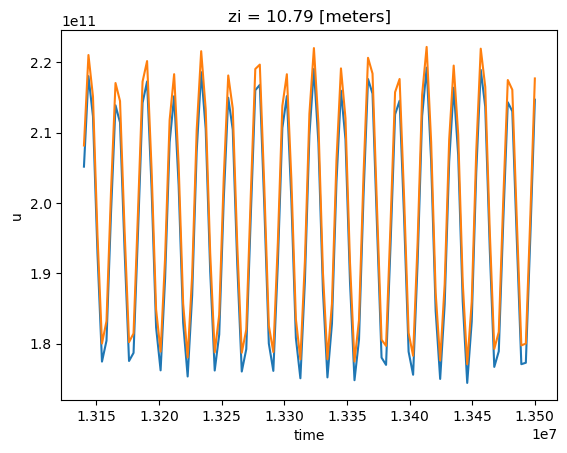

In [4]:
H = 5000
ubt = data.u.fillna(0).integrate("zl")/H
vbt = data.v.fillna(0).integrate("zl")/H

((U**2).sum("mode") + H * ubt**2).sel(xb = slice(300000,1000000)).integrate("yb").integrate("xb").plot()
(data.u**2).fillna(0).integrate("zl").sel(xb = slice(300000,1000000)).integrate("yb").integrate("xb").plot()

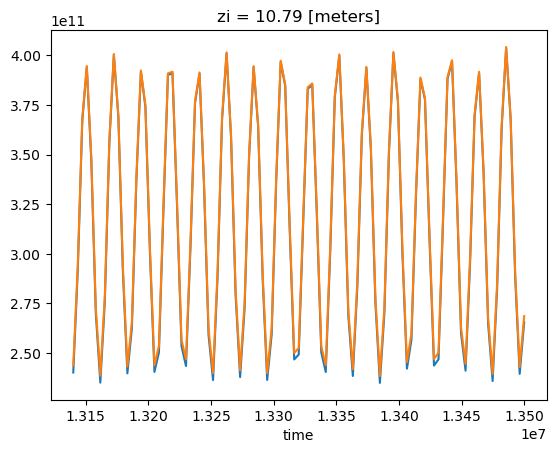

In [73]:
H = 5000
ubt = data.u.fillna(0).integrate("zl")/H
vbt = data.v.fillna(0).integrate("zl")/H

(0.5 * ((V**2 + U**2).sum("mode") + H * (vbt**2 + ubt**2)).sel(xb = slice(300000,1000000)).integrate("yb").integrate("xb")).plot()
(0.5 * (data.v**2 + data.u**2).fillna(0).integrate("zl").sel(xb = slice(300000,1000000)).integrate("yb").integrate("xb")).plot()

## Energy budget in a box as timeseries

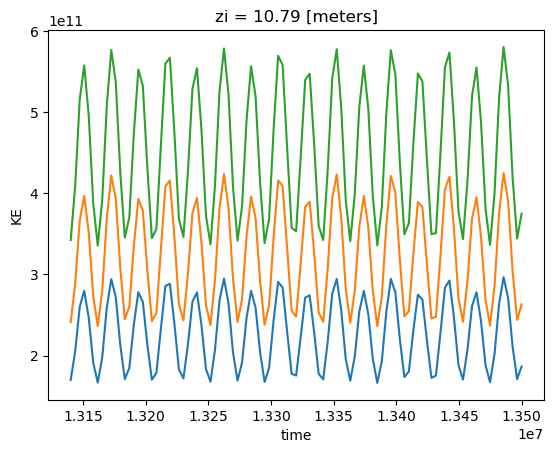

In [11]:
(energies.KE.sum("mode") + energies.KE_bt).integrate("xb").plot()
(0.5 *data.u**2 + 0.5 * data.v**2).sel(xb = slice(300000,1200000)).fillna(0).integrate("zl").integrate("xb").integrate("yb").plot()
data.KE.sel(xb = slice(300000,1200000)).fillna(0).integrate("zl").integrate("xb").integrate("yb").plot()

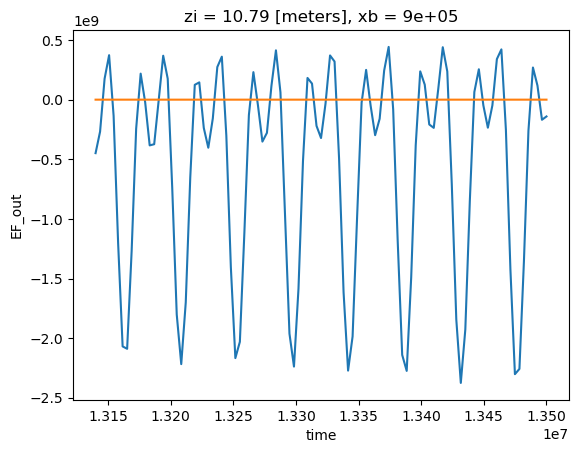

In [27]:
energies.EF_along.sum("mode").isel(xb = 150).plot()
energies.EF_out.sum("mode").isel(xb = 150).plot()

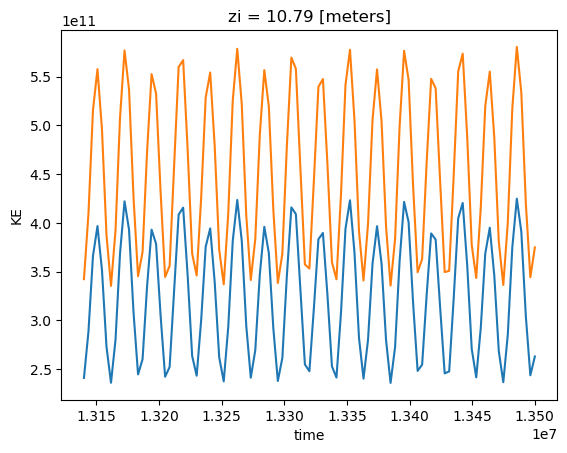

In [28]:
(0.5 * data.u**2 + 0.5 * data.v**2).fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()
data.KE.fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()

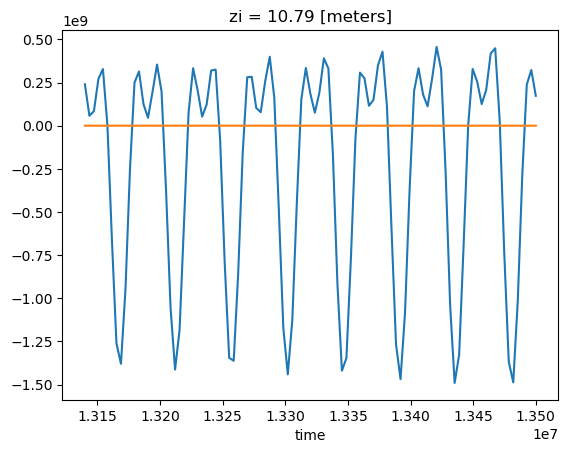

In [19]:
xextent = [500000,504000]
EF_lateral = (energies.EF_along.sel(xb = xextent[-1],method = "nearest") - energies.EF_out.sel(xb = xextent[0],method = "nearest")).sum("mode")
EF_cross = energies.EF_out.sel(xb = slice(xextent[0],xextent[1])).sum("mode").integrate("xb")
(EF_cross + EF_lateral).plot()
# (EF_lateral).plot()
(energies.KE.sum("mode") + energies.KE_bt).sel(xb = slice(xextent[0],xextent[1])).integrate("xb").differentiate("time").plot()

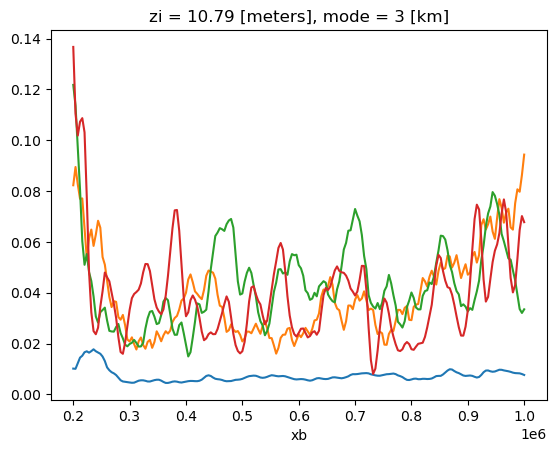

In [14]:
for i in range(4):
    D.isel(mode = i).plot()

In [ ]:
## Now calculate the dissipation rate in space
M2 = (28.984104 / 360) / (3600) 
M2 = 1 / M2# M2 period in seconds
# Calculate phase speed
group_speed = (wavelength * 1000/ M2).sel(xb = 500000,yb = 0,method = "nearest").differentiate("xb") # Phase speed in m/s

D = ahh * (U.differentiate("xb").differentiate("xb") + V.differentiate("yb").differentiate("yb"))**2
D_slope = D / phi

mode = 1
(D_slope.sel(xb = slice(400000,1000000)).fillna(0).sel(zl = slice(0,50)).integrate("zl").sum("mode").mean("time").sel(yb = 0)).plot()
# ((ke.sel(xb = slice(400000,1000000)).differentiate("xb"))).sum("mode").plot()
